In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, Concatenate
from tensorflow.keras.models import Model

def build_generator():
    def conv_block(x, filters, batch_norm=True):
        x = Conv2D(filters, kernel_size=4, strides=2, padding='same')(x)
        if batch_norm:
            x = tf.keras.layers.BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        return x

    def deconv_block(x, skip_input, filters, dropout_rate=0):
        x = Conv2DTranspose(filters, kernel_size=4, strides=2, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        if dropout_rate:
            x = Dropout(dropout_rate)(x)
        x = Concatenate()([x, skip_input])
        x = LeakyReLU(alpha=0.2)(x)
        return x

    inputs = Input(shape=[256, 256, 3])
    e1 = conv_block(inputs, 64, batch_norm=False)
    e2 = conv_block(e1, 128)
    e3 = conv_block(e2, 256)
    e4 = conv_block(e3, 512)
    e5 = conv_block(e4, 512)
    e6 = conv_block(e5, 512)
    e7 = conv_block(e6, 512)
    e8 = conv_block(e7, 512, batch_norm=False)

    d1 = deconv_block(e8, e7, 512, dropout_rate=0.5)
    d2 = deconv_block(d1, e6, 512, dropout_rate=0.5)
    d3 = deconv_block(d2, e5, 512, dropout_rate=0.5)
    d4 = deconv_block(d3, e4, 512)
    d5 = deconv_block(d4, e3, 256)
    d6 = deconv_block(d5, e2, 128)
    d7 = deconv_block(d6, e1, 64)
    d8 = Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh')(d7)

    return Model(inputs, d8)

generator = build_generator()
generator.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 128, 128, 64)         3136      ['input_2[0][0]']             
                                                                                                  
 leaky_re_lu_1 (LeakyReLU)   (None, 128, 128, 64)         0         ['conv2d_2[0][0]']            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 64, 64, 128)          131200    ['leaky_re_lu_1[0][0]']       
                                                                                              

In [3]:
def build_discriminator():
    def d_layer(x, filters, batch_norm=True):
        x = Conv2D(filters, kernel_size=4, strides=2, padding='same')(x)
        if batch_norm:
            x = tf.keras.layers.BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        return x

    input_img = Input(shape=[256, 256, 3])
    target_img = Input(shape=[256, 256, 3])
    combined_imgs = Concatenate()([input_img, target_img])

    d1 = d_layer(combined_imgs, 64, batch_norm=False)
    d2 = d_layer(d1, 128)
    d3 = d_layer(d2, 256)
    d4 = d_layer(d3, 512)
    d5 = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

    return Model([input_img, target_img], d5)

discriminator = build_discriminator()
discriminator.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 concatenate_7 (Concatenate  (None, 256, 256, 6)          0         ['input_3[0][0]',             
 )                                                                   'input_4[0][0]']             
                                                                                                  
 conv2d_10 (Conv2D)          (None, 128, 128, 64)         6208      ['concatenate_7[0][0]'] 

In [5]:
generator.load_weights('/content/generator_epoch_80.h5')
discriminator.load_weights('/content/discriminator_epoch_80.h5')


1/1 [==============================] - 1s 980ms/step
Output image saved to /content/firstmodel.png


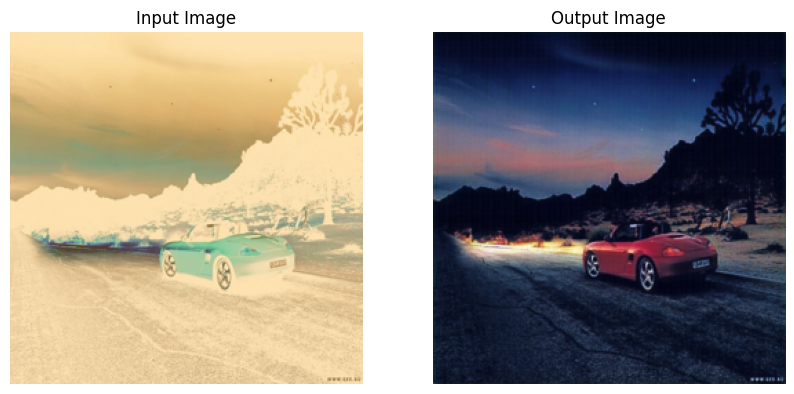

In [6]:
import os
import numpy as np
from PIL import Image, ImageFile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
import matplotlib.pyplot as plt

# To handle truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Function to preprocess input image
def preprocess_image(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize((256, 256))
        img_array = img_to_array(img)
        img_array = (img_array / 127.5) - 1  # Normalize to [-1, 1]
        return np.expand_dims(img_array, axis=0)
    except (OSError, ValueError) as e:
        print(f"Error loading image {image_path}: {e}")
        return None

# Function to postprocess output image
def postprocess_image(img_array):
    img_array = (img_array + 1) * 127.5  # Denormalize to [0, 255]
    img_array = img_array.astype(np.uint8)
    return array_to_img(img_array[0])

# Function to display input and output images
def display_images(input_img_path, output_img):
    input_img = Image.open(input_img_path).convert('RGB')
    input_img = input_img.resize((256, 256))

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(input_img)
    ax[0].set_title('Input Image')
    ax[0].axis('off')

    ax[1].imshow(output_img)
    ax[1].set_title('Output Image')
    ax[1].axis('off')

    plt.show()

# Path to input image (can be a PNG or JPG file)
input_image_path = '/content/drive/MyDrive/Final-Photos/005.png'
output_image_path = '/content/firstmodel.png'

# Process and generate output
input_image = preprocess_image(input_image_path)
if input_image is not None:
    output_image_array = generator.predict(input_image)
    output_image = postprocess_image(output_image_array)

    # Save the generated output image
    output_image.save(output_image_path)
    print(f"Output image saved to {output_image_path}")

    # Display input and output images
    display_images(input_image_path, output_image)
else:
    print("Failed to process the input image.")


In [7]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
model = hub.load(SAVED_MODEL_PATH)

Downloaded https://tfhub.dev/captain-pool/esrgan-tf2/1, Total size: 20.60MB



In [8]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, ToPILImage
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img # Import necessary functions

def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)
# Function to postprocess output image


In [9]:
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

Saved as Original Image.jpg


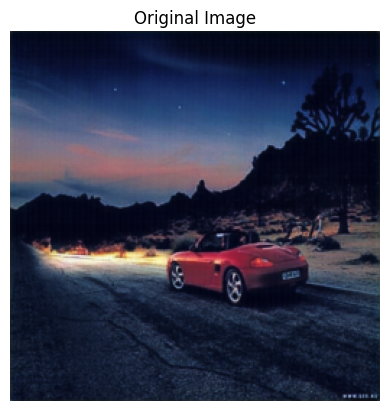

In [10]:
hr_image = preprocess_image('/content/firstmodel.png')
# Plotting Original Resolution image
plot_image(tf.squeeze(hr_image), title="Original Image")
save_image(tf.squeeze(hr_image), filename="Original Image")

Time Taken: 17.182800
Saved as Super Resolution.jpg


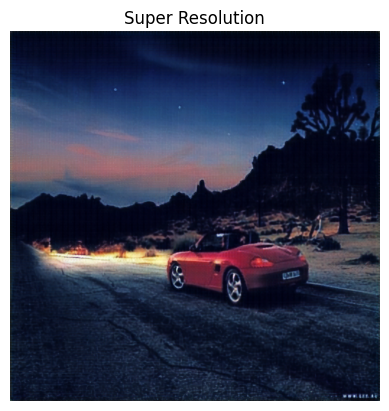

In [11]:
model = hub.load(SAVED_MODEL_PATH)
start = time.time()
fake_image = model(hr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))
# Plotting Super Resolution image
plot_image(fake_image, title="Super Resolution")
save_image(fake_image, filename="Super Resolution")

1/1 [==============================] - 1s 873ms/step
Intermediate output image saved to /content/finalone/intermediate_output.png
Time Taken for Super Resolution: 16.870506
Final output image saved to /content/finalone/final_output.png


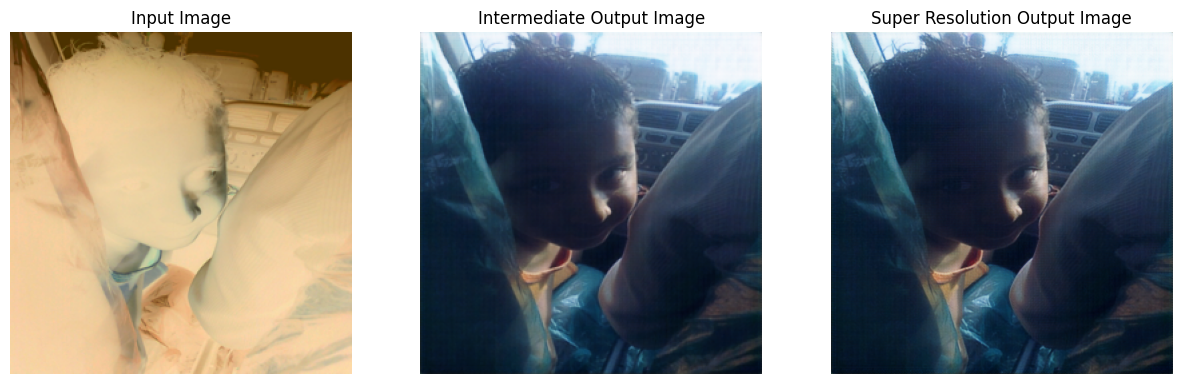

In [14]:
import os
import time
import numpy as np
import tensorflow as tf
from PIL import Image, ImageFile
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
import matplotlib.pyplot as plt
import tensorflow_hub as hub

# To handle truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Preprocess and postprocess functions for Pix2Pix GAN
def preprocess_image(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize((256, 256))
        img_array = img_to_array(img)
        img_array = (img_array / 127.5) - 1  # Normalize to [-1, 1]
        return np.expand_dims(img_array, axis=0)
    except (OSError, ValueError) as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def postprocess_image(img_array):
    img_array = (img_array + 1) * 127.5  # Denormalize to [0, 255]
    img_array = img_array.astype(np.uint8)
    return array_to_img(img_array[0])

# Preprocess and postprocess functions for ESRGAN
def preprocess_hr_image(image):
    hr_image = tf.image.decode_image(tf.io.read_file(image))
    if hr_image.shape[-1] == 4:
        hr_image = hr_image[...,:-1]
    hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
    hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
    hr_image = tf.cast(hr_image, tf.float32)
    return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
    if not isinstance(image, Image.Image):
        image = tf.clip_by_value(image, 0, 255)
        image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
    image.save("%s.jpg" % filename)
    print("Saved as %s.jpg" % filename)

def plot_image(image, title=""):
    image = np.asarray(image)
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
    plt.imshow(image)
    plt.axis("off")
    plt.title(title)

# Load the Pix2Pix GAN model
def build_generator():
    def conv_block(x, filters, batch_norm=True):
        x = tf.keras.layers.Conv2D(filters, kernel_size=4, strides=2, padding='same')(x)
        if batch_norm:
            x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
        return x

    def deconv_block(x, skip_input, filters, dropout_rate=0):
        x = tf.keras.layers.Conv2DTranspose(filters, kernel_size=4, strides=2, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        if dropout_rate:
            x = tf.keras.layers.Dropout(dropout_rate)(x)
        x = tf.keras.layers.Concatenate()([x, skip_input])
        x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
        return x

    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    e1 = conv_block(inputs, 64, batch_norm=False)
    e2 = conv_block(e1, 128)
    e3 = conv_block(e2, 256)
    e4 = conv_block(e3, 512)
    e5 = conv_block(e4, 512)
    e6 = conv_block(e5, 512)
    e7 = conv_block(e6, 512)
    e8 = conv_block(e7, 512, batch_norm=False)

    d1 = deconv_block(e8, e7, 512, dropout_rate=0.5)
    d2 = deconv_block(d1, e6, 512, dropout_rate=0.5)
    d3 = deconv_block(d2, e5, 512, dropout_rate=0.5)
    d4 = deconv_block(d3, e4, 512)
    d5 = deconv_block(d4, e3, 256)
    d6 = deconv_block(d5, e2, 128)
    d7 = deconv_block(d6, e1, 64)
    d8 = tf.keras.layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh')(d7)

    return tf.keras.models.Model(inputs, d8)

generator = build_generator()
generator.load_weights('/content/generator_epoch_80.h5')

# Load ESRGAN model from TensorFlow Hub
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
esrgan_model = hub.load(SAVED_MODEL_PATH)

# Input and output paths
input_image_path = '/content/drive/MyDrive/Final-Photos/Image0309000.png'
intermediate_image_path = '/content/finalone/intermediate_output.png'
output_image_path = '/content/finalone/final_output.png'

# Process with Pix2Pix GAN
input_image = preprocess_image(input_image_path)
if input_image is not None:
    intermediate_output_array = generator.predict(input_image)
    intermediate_output_image = postprocess_image(intermediate_output_array)
    intermediate_output_image.save(intermediate_image_path)
    print(f"Intermediate output image saved to {intermediate_image_path}")

    # Process with ESRGAN
    hr_image = preprocess_hr_image(intermediate_image_path)
    start = time.time()
    sr_image = esrgan_model(hr_image)
    sr_image = tf.squeeze(sr_image)
    print("Time Taken for Super Resolution: %f" % (time.time() - start))

    # Save and display the final output
    sr_image_pil = tf.clip_by_value(sr_image, 0, 255).numpy().astype(np.uint8)
    sr_image_pil = Image.fromarray(sr_image_pil)
    sr_image_pil.save(output_image_path)
    print(f"Final output image saved to {output_image_path}")

    # Display input, intermediate, and final output images
    input_img = Image.open(input_image_path).convert('RGB').resize((256, 256))
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(input_img)
    ax[0].set_title('Input Image')
    ax[0].axis('off')

    ax[1].imshow(intermediate_output_image)
    ax[1].set_title('Intermediate Output Image')
    ax[1].axis('off')

    ax[2].imshow(sr_image_pil)
    ax[2].set_title('Super Resolution Output Image')
    ax[2].axis('off')

    plt.show()
else:
    print("Failed to process the input image.")

